# 0 - Import das bibliotecas necessárias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.metrics
import itertools

import tensorflow_datasets as tfds

# 1 - Treinamento

Carregando a base de dados no conjunto de treinamento e de teste:

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Normalizando as imagens do tipo `tf.uint8` para o tipo `tf.float32`, esperado pelo modelo, e embaralhando as amostras para garantir a aleatoriedade da base de treino, depois de armazenar a base de treinamento em cache para melhor performance. Também combinando elementos adjacentes do conjunto em batches para ter batches únicos em em cada época e fazendo o prefetching, para melhorar a performance.

In [3]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

Normalizando as imagens para o conjunto de teste.

In [4]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

Definindo a sequência de camadas do modelo com duas camadas ocultas de 96 neurônios e o configurando (usando o método `model.compile`) com o algoritmo Adam para otimização, usando como função custo a entropia cruzada entre os rótulos e predições e como métrica de performance também a entropia cruzada.

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(96, activation='relu'),
  tf.keras.layers.Dense(96, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

Treinando o modelo usando 10 épocas.

In [6]:
model.fit(
    ds_train,
    epochs=10
)

Epoch 1/10
469/469 [==============================] - 2s 1ms/step - loss: 0.3467 - sparse_categorical_accuracy: 0.9035
Epoch 2/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1439 - sparse_categorical_accuracy: 0.9572
Epoch 3/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9703
Epoch 4/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0763 - sparse_categorical_accuracy: 0.9764
Epoch 5/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0612 - sparse_categorical_accuracy: 0.9814
Epoch 6/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0506 - sparse_categorical_accuracy: 0.9843
Epoch 7/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9875
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0342 - sparse_categorical_accuracy: 0.9890
Epoch 9/10
469/469 [============================

Usando o método `model.summary` para exibir o número de variáveis treináveis ("trainable params" na tabela criada abaixo).

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 96)                75360     
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                                 
 dense_2 (Dense)             (None, 10)                970       
                                                                 
Total params: 85,642
Trainable params: 85,642
Non-trainable params: 0
_________________________________________________________________


Salvando o modelo na pasta `saved_model`, e criando essa pasta caso ela não exista.

In [8]:
!mkdir -p saved_model
model.save('saved_model/my_model')

Já existe uma subpasta ou um arquivo -p.
Erro ao processar: -p.
Já existe uma subpasta ou um arquivo saved_model.
Erro ao processar: saved_model.


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


# 2 - Avaliação do modelo

Recuperando o modelo salvo.

In [9]:
loaded_model = tf.keras.models.load_model('saved_model/my_model')

Recuperando as imagens e rótulos do conjunto de teste a partir da base de dados `ds_test` e as convertendo para "numpy arrays".

In [10]:
images, labels = tuple(zip(*ds_test))

x_test = np.array(images)
y_test = np.array(labels)

Rodando o modelo no conjunto de imagens `x_test`.

In [11]:
test_predictions = np.argmax(loaded_model.predict(x_test),axis=1)

313/313 [==============================] - 0s 652us/step


Gerando a matriz de confusão `cm` usando o `sklearn`.

In [12]:
cm = sklearn.metrics.confusion_matrix(y_test, test_predictions)

Exibindo a matriz de confusão usando o `pyplot`, escrevendo em cada "bin" da matriz o valor percentual correspondente.

Text(0.5, 89.87999999999997, 'Predicted label')

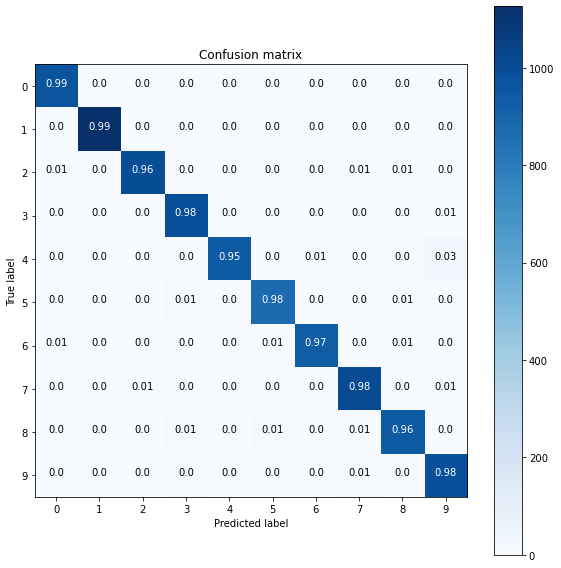

In [13]:
class_names = ['0','1','2','3','4','5','6','7','8','9']

figure = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Achando o valor percentual para cada elemento da matriz:
percent = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

# Escrevendo os valores acima na matriz, em preto se o fundo for claro
# ou em branco se o fundo for escuro.
threshold = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, percent[i, j], horizontalalignment="center", color=color)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Calculando as métricas pedidas nas especificações.

In [14]:
precision = sklearn.metrics.precision_score(y_test, test_predictions, average='micro')
recall = sklearn.metrics.recall_score(y_test, test_predictions, average='micro')
f1 = sklearn.metrics.f1_score(y_test, test_predictions, average='micro')
accuracy = sklearn.metrics.accuracy_score(y_test, test_predictions)

print("Precisão:   {0} \nRecall:     {1} \nMétrica F1: {2} \nAcurácia:   {3} \n".format(precision, recall, f1, accuracy))

Precisão:   0.975 
Recall:     0.975 
Métrica F1: 0.975 
Acurácia:   0.975 

